In [1]:
import pandas as pd
import numpy as np
import pickle
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, MultiTaskElasticNetCV, ElasticNetCV, LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from xgboost import XGBClassifier, XGBRegressor

import seaborn as sns

from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.svm import SVC

In [2]:
import logging
logger = logging.getLogger('causalml')
logging.basicConfig(level=logging.INFO)

In [3]:
data_path='../Processed/final/'
save_path='../Processed/final/'

# Import data

In [4]:
(Y_train, T_train, X_train, W_train)=pickle.load(open(data_path+'YTXW_train.pkl','rb'))
(Y_test, T_test, X_test, W_test)=pickle.load(open(data_path+'YTXW_test.pkl','rb'))
(Y_val, T_val, X_val, W_val)=pickle.load(open(data_path+'YTXW_val.pkl','rb'))

In [5]:
le_dx=pickle.load(open(data_path+'le_dx.pkl','rb'))
le_patid=pickle.load(open(data_path+'le_patid.pkl','rb'))
selected_patient_feature=['age_onset','obs_win','female']+['race__'+c for c in ['A','B','H','U','W']]
rx2id = pickle.load(open(data_path+'drug_dict.pkl', 'rb'))

# Process Y,T,W,X

Several steps:
- Standardize age
- Combine demographics with dx information 
- Set treatment and control group
- Output a dataframe

In [6]:
from sklearn import preprocessing

def prepare(y, t, w, x, rx2id, target):
    patid_temp = list(w['patid'].unique())
    temp_le = preprocessing.LabelEncoder()
    temp_le.fit(list(patid_temp))
    w['row_idx'] = temp_le.transform(w['patid'])
    
    w_sparse = csr_matrix((w['log_count'], (w['row_idx'], w['phecode3'])))
    w = w_sparse.toarray()
    
    x_temp = np.concatenate((w, x.values), axis=1)
    
    treatment_train = [0] * len(t)
    temp_index = t.index
    idx = 0

    def get_classes(value):
        return [k for k, v in rx2id.items() if v == value]

    for i in temp_index:
        classes = t.loc[i, 'antiasthma']
        if (classes != target):
            treatment_train[idx] = 'control'
        else:
            treatment_train[idx] = 'treatment'
        idx += 1
        
    treatment = pd.DataFrame(treatment_train)
    treatment.index = temp_index
    treatment.columns = ['treatment']
    
    y = pd.DataFrame(y)
    feature_df = pd.DataFrame(x_temp)
    feature_df.index = y.index
    
    df = pd.concat([y, treatment, t, feature_df], axis=1)
    df.index = np.arange(0, len(df))
    return df

# Benchmark (Agonist)

In [7]:
target = 4
df_val0 = prepare(Y_val, T_val, W_val, X_val, rx2id, target)
df_test0 = prepare(Y_test, T_test, W_test, X_test, rx2id, target)
df_train0 = prepare(Y_train, T_train, W_train, X_train, rx2id, target)

In [8]:
x_train0 = df_train0.iloc[:, 5:]
x_test0 = df_test0.iloc[:, 5:]
x_val0 = df_val0.iloc[:, 5:]

In [9]:
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.metrics import plot_gain, auuc_score
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseSClassifier, BaseTClassifier, BaseXClassifier, BaseRClassifier
from causalml.feature_selection.filters import FilterSelect

from causalml.propensity import GradientBoostedPropensityModel
from causalml.propensity import compute_propensity_score

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import ElasticNet

In [10]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## Propensity score estimation

In [11]:
t = df_train0['treatment']

In [12]:
treatment = [0] * len(t)
for i in range(len(t)):
    if t[i] == 'control':
        treatment[i] = 0
    else:
        treatment[i] = 1

In [13]:
t_test = df_test0['treatment']
treatment_test = [0] * len(t_test)
for i in range(len(t_test)):
    if t_test[i] == 'control':
        treatment_test[i] = 0
    else:
        treatment_test[i] = 1 

In [14]:
t_val = df_val0['treatment']
treatment_val = [0] * len(t_val)
for i in range(len(t_val)):
    if t_val[i] == 'control':
        treatment_val[i] = 0
    else:
        treatment_val[i] = 1 

### Logistic regression

In [15]:
glm = LogisticRegression(max_iter = 3000)
glm.fit(x_train0, treatment)

LogisticRegression(max_iter=3000)

In [16]:
t_pred_p = glm.predict_proba(x_val0)

In [17]:
lr_probs = t_pred_p[:, 1]

In [18]:
lr_probs

array([0.00953289, 0.03311877, 0.16293793, ..., 0.03869499, 0.07684168,
       0.0301836 ])

In [19]:
roc_auc_score(treatment_val, lr_probs)

0.5379132195343317

### Random Forest

In [20]:
rf = RandomForestClassifier(max_depth=6, random_state=1105)
rf.fit(x_train0, treatment)

RandomForestClassifier(max_depth=6, random_state=1105)

In [21]:
t_pred_p = rf.predict_proba(x_val0)
lr_probs = t_pred_p[:, 1]
roc_auc_score(treatment_val, lr_probs)

0.5686127692253988

### XGBC

In [22]:
xgb = XGBClassifier(max_depth=6, random_state=1105, n_estimators=100)
xgb.fit(x_train0, treatment)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              random_state=1105, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [23]:
t_pred_p = xgb.predict_proba(x_val0)
lr_probs = t_pred_p[:, 1]
roc_auc_score(treatment_val, lr_probs)

0.5168988026669459

### Gradient Boosting Method

In [24]:
gbc = GradientBoostingClassifier(max_depth = 6, random_state = 1105)

In [25]:
gbc.fit(x_train0, treatment)

GradientBoostingClassifier(max_depth=6, random_state=1105)

In [26]:
t_pred_p = gbc.predict_proba(x_val0)
lr_probs = t_pred_p[:, 1]
roc_auc_score(treatment_val, lr_probs)

0.5647711802282962

### Model with feature selection

In [27]:
glm_l1 = LogisticRegression(penalty='elasticnet', max_iter = 3000, solver='saga', l1_ratio=0.1)
glm_l1.fit(x_train0, treatment)

LogisticRegression(l1_ratio=0.1, max_iter=3000, penalty='elasticnet',
                   solver='saga')

In [28]:
t_pred_p = glm_l1.predict_proba(x_val0)

In [29]:
lr_probs = t_pred_p[:, 1]

In [30]:
roc_auc_score(treatment_val, lr_probs)

0.5399588089503264

## Propensity score matching

In [31]:
score = xgb.predict_proba(x_train0)[:, 1]
df_train0['score'] = score
df_train0['T'] = treatment

In [32]:
score = list(score)

In [33]:
df_train0

,adrd,treatment,patid,antiasthma,log_count,0,1,2,3,4,...,241,242,243,244,245,246,247,248,score,T
0,0,control,9722,1,1.945910,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,75.0,1.0,1.0,0.0,0.0,0.0,0.0,0.001588,0
1,0,control,1232,5,1.386294,0.0,0.000000,1.098612,1.098612,0.693147,...,0.0,72.0,0.0,0.0,0.0,0.0,0.0,1.0,0.005901,0
2,0,control,2220,1,3.583519,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,74.0,0.0,0.0,0.0,0.0,0.0,1.0,0.004296,0
3,0,treatment,1806,4,0.693147,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,83.0,1.0,0.0,0.0,1.0,0.0,0.0,0.902533,1
4,0,control,9768,2,1.386294,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,84.0,0.0,0.0,0.0,0.0,0.0,1.0,0.016323,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6766,0,control,9185,3,3.044522,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,90.0,0.0,0.0,0.0,0.0,0.0,1.0,0.020429,0
6767,1,control,9752,1,1.609438,0.0,0.000000,0.693147,0.000000,0.000000,...,0.0,83.0,1.0,0.0,0.0,0.0,0.0,1.0,0.012474,0
6768,0,control,3868,1,0.693147,0.0,0.000000,0.693147,0.000000,0.000000,...,0.0,88.0,0.0,0.0,0.0,1.0,0.0,0.0,0.008146,0
6769,0,control,6972,1,0.693147,0.0,0.000000,0.693147,0.000000,0.000000,...,0.0,89.0,0.0,0.0,0.0,0.0,0.0,1.0,0.004833,0


In [34]:
from causalml.match import NearestNeighborMatch, create_table_one

psm = NearestNeighborMatch(replace=False,
                           ratio=1,
                           random_state=42)

matched = psm.match(data=df_train0,
                    treatment_col='T',
                    score_cols=['score'])


In [35]:
sum(treatment)

432

In [36]:
matched

,adrd,treatment,patid,antiasthma,log_count,0,1,2,3,4,...,241,242,243,244,245,246,247,248,score,T
2124,0,treatment,4305,4,3.931826,0.000000,0.0,0.0,0.0,0.0,...,0.0,85.0,1.0,0.0,0.0,0.0,0.0,1.0,0.228209,1
3538,0,treatment,5255,4,3.433987,0.000000,0.0,0.0,0.0,0.0,...,0.0,84.0,0.0,0.0,0.0,0.0,0.0,1.0,0.119785,1
2741,0,treatment,3407,4,1.609438,0.000000,0.0,0.0,0.0,0.0,...,0.0,82.0,1.0,0.0,0.0,0.0,0.0,1.0,0.142648,1
4180,0,control,2680,1,4.094345,0.000000,0.0,0.0,0.0,0.0,...,0.0,77.0,0.0,0.0,1.0,0.0,0.0,0.0,0.198596,0
6465,0,control,2907,3,1.945910,1.098612,0.0,0.0,0.0,0.0,...,0.0,83.0,1.0,0.0,0.0,0.0,0.0,1.0,0.123983,0
2407,0,control,7793,5,2.708050,0.000000,0.0,0.0,0.0,0.0,...,0.0,79.0,1.0,0.0,1.0,0.0,0.0,0.0,0.143181,0


# Meta-learners

In [37]:
l = len(x_train0)
score = xgb.predict_proba(x_train0)
e = {t: score[0:l, t] for t in np.unique(treatment)}

In [38]:
pickle.dump(e, open(save_path+'ps1.pkl', 'wb'))

## S-learner

### Logistic regression based

In [39]:
learner_s = BaseSClassifier(learner=LogisticRegression(max_iter=3000), control_name='control')
learner_s.fit(X=x_train0,treatment=df_train0['treatment'],y=df_train0['adrd'])

In [40]:
cate_s = learner_s.predict(X=x_test0, treatment=df_test0['treatment'], y=df_test0['adrd'])
test_learner_s = BaseSClassifier(learner=LogisticRegression(max_iter=3000), control_name='control')
test_cate_s = test_learner_s.fit_predict(X=x_test0,
                treatment=df_test0['treatment'],
                y=df_test0['adrd'])

INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.5460
INFO:causalml:     AUC (Treatment):     0.5902
INFO:causalml:Log Loss   (Control):     0.3792
INFO:causalml:Log Loss (Treatment):     0.5010
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.9444
INFO:causalml:     AUC (Treatment):     0.9126
INFO:causalml:Log Loss   (Control):     0.1862
INFO:causalml:Log Loss (Treatment):     0.2772


In [41]:
((cate_s-test_cate_s)**2).mean()**(1/2)

0.04343987632282827

In [42]:
cate_s.var()

0.0004059674726682077

### Random Forest base learner

In [43]:
learner_srf = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
learner_srf.fit(X=x_train0,treatment=df_train0['treatment'],y=df_train0['adrd'])

In [44]:
cate_srf = learner_srf.predict(X=x_test0, treatment=df_test0['treatment'], y=df_test0['adrd'])
test_learner_srf = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
test_cate_srf = test_learner_srf.fit_predict(X=x_test0,
                treatment=df_test0['treatment'], y=df_test0['adrd'])

INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.5375
INFO:causalml:     AUC (Treatment):     0.5328
INFO:causalml:Log Loss   (Control):     0.3660
INFO:causalml:Log Loss (Treatment):     0.5177
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.9837
INFO:causalml:     AUC (Treatment):     0.9694
INFO:causalml:Log Loss   (Control):     0.2419
INFO:causalml:Log Loss (Treatment):     0.3346


In [45]:
((cate_srf-test_cate_srf)**2).mean()**(1/2)

0.00836723271987844

In [46]:
cate_srf.var()

2.3542979644549976e-05

### XGBoosting

In [47]:
learner_sxg = BaseSClassifier(learner=XGBClassifier(max_depth=6, random_state=1105, n_estimators=100), control_name='control')
learner_sxg.fit(X=x_train0,treatment=df_train0['treatment'],y=df_train0['adrd'])
cate_sxg = learner_sxg.predict(X=x_test0, treatment=df_test0['treatment'])
test_learner_sxg = BaseSClassifier(learner=XGBClassifier(max_depth=6, random_state=1105, n_estimators=100), control_name='control')
test_cate_sxg = test_learner_sxg.fit_predict(X=x_test0, treatment=df_test0['treatment'], y=df_test0['adrd'])
((cate_sxg-test_cate_sxg)**2).mean()**(1/2)

INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     1.0000
INFO:causalml:     AUC (Treatment):     1.0000
INFO:causalml:Log Loss   (Control):     0.0077
INFO:causalml:Log Loss (Treatment):     0.0132


0.0677429501055442

## T-learner

### Logistic regression

In [48]:
learner_t = BaseTClassifier(learner = LogisticRegression(max_iter = 3000), control_name='control')
learner_t.fit(X=x_train0, treatment=df_train0['treatment'], y=df_train0['adrd'])

In [49]:
cate_t = learner_t.predict(X=x_test0, treatment=df_test0['treatment'], y=df_test0['adrd'])

INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.5501
INFO:causalml:     AUC (Treatment):     0.6218
INFO:causalml:Log Loss   (Control):     0.3797
INFO:causalml:Log Loss (Treatment):     0.8605


In [50]:
test_learner_t = BaseTClassifier(learner = LogisticRegression(max_iter = 3000), control_name='control')
test_cate_t = test_learner_t.fit_predict(X=x_test0, treatment=df_test0['treatment'], y=df_test0['adrd'])

INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.9502
INFO:causalml:     AUC (Treatment):     1.0000
INFO:causalml:Log Loss   (Control):     0.1792
INFO:causalml:Log Loss (Treatment):     0.0452


In [51]:
((cate_t-test_cate_t)**2).mean()**(1/2)

0.38231071959992924

### Random Forest

In [52]:
learner_trf = BaseTClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
learner_trf.fit(X=x_train0,treatment=df_train0['treatment'],y=df_train0['adrd'])
cate_trf = learner_trf.predict(X=x_test0, treatment=df_test0['treatment'])
test_learner_trf = BaseTClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
test_cate_trf = test_learner_trf.fit_predict(X=x_test0,
                treatment=df_test0['treatment'], y=df_test0['adrd'])
((cate_trf-test_cate_trf)**2).mean()**(1/2)

INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.9842
INFO:causalml:     AUC (Treatment):     1.0000
INFO:causalml:Log Loss   (Control):     0.2335
INFO:causalml:Log Loss (Treatment):     0.1904


0.10401344223578947

### XGBoosting

In [53]:
learner_txg = BaseTClassifier(learner=XGBClassifier(max_depth=6, random_state=1105, n_estimators=100), control_name='control')
learner_txg.fit(X=x_train0,treatment=df_train0['treatment'],y=df_train0['adrd'])
cate_txg = learner_txg.predict(X=x_test0, treatment=df_test0['treatment'])
test_learner_txg = BaseTClassifier(learner=XGBClassifier(max_depth=6, random_state=1105, n_estimators=100), control_name='control')
test_cate_txg = test_learner_txg.fit_predict(X=x_test0, treatment=df_test0['treatment'], y=df_test0['adrd'])
((cate_txg-test_cate_txg)**2).mean()**(1/2)

INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     1.0000
INFO:causalml:     AUC (Treatment):     1.0000
INFO:causalml:Log Loss   (Control):     0.0074
INFO:causalml:Log Loss (Treatment):     0.0229


0.3337226418734146

## X-learner

In [54]:
l = len(x_train0)
score = xgb.predict_proba(x_train0)
e = {t: score[0:l, t] for t in np.unique(treatment)}

l_test = len(x_test0)
score_test = xgb.predict_proba(x_test0)
e_test = {t: score[0:l_test, t] for t in np.unique(treatment_test)}

treatment = np.array(treatment)
treatment_test = np.array(treatment_test)

### Logistic regression

In [55]:
learner_x = BaseXClassifier(outcome_learner=LogisticRegression(max_iter=3000),
                            effect_learner=ElasticNetCV(max_iter=3000, random_state=1105))
learner_x.fit(X=x_train0, treatment=treatment, y=df_train0['adrd'], p=e)
cate_x = learner_x.predict(X=x_test0, treatment=treatment_test, p=e_test)
test_learner_x = BaseXClassifier(outcome_learner=LogisticRegression(max_iter=3000), 
                                 effect_learner=ElasticNetCV(max_iter=3000, random_state=1105))
test_cate_x = test_learner_x.fit_predict(X=x_test0, treatment=treatment_test, y=df_test0['adrd'], p=e_test)
((cate_x-test_cate_x)**2).mean()**(1/2)

INFO:causalml:Error metrics for group 1
INFO:causalml:     AUC   (Control):     0.9502
INFO:causalml:     AUC (Treatment):     1.0000
INFO:causalml:Log Loss   (Control):     0.1792
INFO:causalml:Log Loss (Treatment):     0.0452


0.10319156543359748

### Random Forest

In [56]:
learner_xrf = BaseXClassifier(outcome_learner=RandomForestClassifier(random_state=1105, max_depth=6),
                            effect_learner=RandomForestRegressor(random_state=1105, max_depth=6))
learner_xrf.fit(X=x_train0, treatment=treatment, y=df_train0['adrd'], p=e)
cate_xrf = learner_xrf.predict(X=x_test0, treatment=treatment_test, p=e_test)
test_learner_xrf = BaseXClassifier(outcome_learner=RandomForestClassifier(random_state=1105, max_depth=6), 
                                 effect_learner=RandomForestRegressor(random_state=1105, max_depth=6))
test_cate_xrf = test_learner_xrf.fit_predict(X=x_test0, treatment=treatment_test, y=df_test0['adrd'], p=e_test)
((cate_xrf-test_cate_xrf)**2).mean()**(1/2)

INFO:causalml:Error metrics for group 1
INFO:causalml:     AUC   (Control):     0.9842
INFO:causalml:     AUC (Treatment):     1.0000
INFO:causalml:Log Loss   (Control):     0.2335
INFO:causalml:Log Loss (Treatment):     0.1904


0.1604556537109791

### XGB

In [57]:
learner_xgb = BaseXClassifier(outcome_learner=XGBClassifier(random_state=1105, max_depth=6, n_estimators =100),
                             effect_learner=XGBRegressor(random_state=1105, max_depth=6))
learner_xgb.fit(X=x_train0, treatment=treatment, y=df_train0['adrd'], p=e)
cate_xgb = learner_xgb.predict(X=x_test0, treatment=treatment_test, p=e_test)
test_learner_xgb = BaseXClassifier(outcome_learner=XGBClassifier(random_state=1105, max_depth=6, n_estimators =100),
                             effect_learner=XGBRegressor(random_state=1105, max_depth=6))
test_cate_xgb = test_learner_xgb.fit_predict(X=x_test0, treatment=treatment_test, y=df_test0['adrd'], p=e_test)
((cate_xgb-test_cate_xgb)**2).mean()**(1/2)

INFO:causalml:Error metrics for group 1
INFO:causalml:     AUC   (Control):     1.0000
INFO:causalml:     AUC (Treatment):     1.0000
INFO:causalml:Log Loss   (Control):     0.0074
INFO:causalml:Log Loss (Treatment):     0.0229


0.3084432053279013

## R-learner

### Logistic regression

In [58]:
learner_r = BaseRClassifier(outcome_learner=LogisticRegression(max_iter=3000),
                            effect_learner=ElasticNet(max_iter=3000, random_state=1105))
learner_r.fit(X=x_train0, treatment=treatment, y=df_train0['adrd'], p=e)
cate_r = learner_r.predict(X=x_test0, p=e_test)
test_learner_r = BaseRClassifier(outcome_learner=LogisticRegression(max_iter=3000), 
                                 effect_learner=ElasticNet(max_iter=3000, random_state=1105))
test_cate_r = test_learner_r.fit_predict(X=x_test0, treatment=treatment_test, y=df_test0['adrd'], p=e_test)
((cate_r-test_cate_r)**2).mean()**(1/2)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for 1 with R-loss
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for 1 with R-loss


0.1775468026677443

### XGBoosting

In [59]:
x_train = np.array(x_train0)
x_test = np.array(x_test0)

In [60]:
learner_rgb = BaseRClassifier(outcome_learner=XGBClassifier(random_state=1105, max_depth=5, n_estimators =100),
                             effect_learner=XGBRegressor(random_state=1105, max_depth=5))
learner_rgb.fit(X=x_train, treatment=treatment, y=df_train0['adrd'], p=e)
cate_rgb = learner_rgb.predict(X=x_test, p=e_test)
test_learner_rgb = BaseRClassifier(outcome_learner=XGBClassifier(random_state=1105, max_depth=5, n_estimators =100),
                             effect_learner=XGBRegressor(random_state=1105, max_depth=5))
test_cate_rgb = test_learner_rgb.fit_predict(X=x_test, treatment=treatment_test, y=df_test0['adrd'], p=e_test)
((cate_rgb-test_cate_rgb)**2).mean()**(1/2)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for 1 with R-loss
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for 1 with R-loss


1.096510470069048

## Evaluation

In [61]:
import matplotlib.pyplot as plt

In [62]:
data1 = [cate_srf.flatten(), cate_trf.flatten(), cate_xrf.flatten()] 

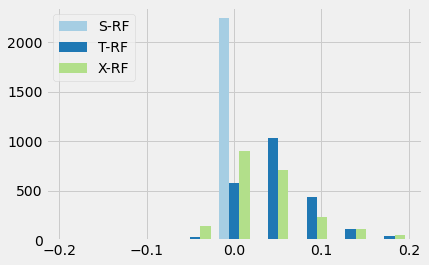

In [63]:
bins = np.linspace(-0.2, 0.2, 10)
plt.hist(data1, bins, label = ['S-RF', 'T-RF', 'X-RF'])
plt.legend(loc='upper left')